<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Inverse Problems</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Probabilistic Inversion: Simulated annealing</div>
        </div>
    </div>
</div>

##### Authors:
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

* Kilian Gessele ([@KGessele](https://github.com/KGessele))

* Berta Vilacís ([@bvilacis](https://github.com/bvilacis))

---

This notebook presents a technique for finding the maximum likely point of a multi-modal function while sampling it. Our function is a probability density function (pdf) and the method used is called simulated annealing, a Markov Chain Monte Carlo method (MCMC). 

This method is inspired by the annealing process in solid state physics. Annealing is a physical process of heating a solid until thermal stresses are released, then cooling it very slowly until the crystals are perfectly arranged, acheiving a minimum energy state. Depending on how fast or slow the temperature is cooled, the results will have worse or better the quality. 

![alt text](crystal.jpg "Title")
Photo: Gavin Smith - https://bit.ly/2IzAkcE}




The simulation of this process is known as Simualted Annealing. It is a mathematical analogy which can be used to sample highly nonlinear functions, multidimensional functions. The analogy of the slow temperature cooling is the decrese on the probablitiy of accepting worse solutions as the space is explored; instead, the probability for going to a better solution is kept to 1. At high temperatures the system is allowed to explore the whole space, and at low temperatures exist a restriction in the exploration. The decrease of the temperature has to be done carefully, due to the aim is to find the global minimum state of energy. If it is done too fast you can obtain a secondary minima, and if it is too slow you will waste a lot of forward calculations.  



This analogy between the physical process of annealing and the mathematical problem of obtaining a global minimum of a function allow us to finding the maximum likelihood point. 

First we will define an energy function: 
\begin{equation}
S(m) = - T_0 log\frac{\sigma_M(m)}{\rho_M(m)}
\end{equation}
where $m$ is refered to the coordinates in the space, $T_0$ is a fixed positive number termed the ambient temperature (e.g. $T=1$), $\sigma_M(m)$ is the designed function and $\rho_M(m)$ is a parameter. 
We obtain the probability density function as a function of the temperature of the system
\begin{equation}
\sigma_M(m,T)=\rho_M(m) exp \bigg( -\frac{S(m)}{T} \bigg) = \rho_M(m) exp \bigg( -\frac{-T_0 log\frac{\sigma_M(m)} {\rho_M(m)}}{T} \bigg)
\end{equation}


In [1]:
# Import Libraries (PLEASE RUN THIS CODE FIRST!) 
# ----------------------------------------------
import numpy as np
import matplotlib
## Show Plot in The Notebook
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from IPython import display


from mpl_toolkits.mplot3d import Axes3D

**PARAMETER CONFIGURATION**

The above expression helps us to understand the relationship between our pdf and the temperature. For this notebook is considered that $\rho_M(m) = 1$ and $T_0 = 1$, with the expresion beeing
\begin{equation}
\sigma_M(m,T)= exp \bigg( -\frac{-log(\sigma_M(m))}{T} \bigg)
\end{equation}



In [2]:
# Parameter Configuration
# ----------------------

# Some global parameters

npp = 1000000  #number of tries to take
ns = 100   # number of samples to keep 
T0 = 1.
T = T0
alpha = 0.99999 #cooling schedule

rho = 1 # manteining it constant
rho0 = 1 # mantening it constant
Tplots = 10 # inicial temperature for the plots
stepT = 4 #how many steps should the Temperature be *0.1 evolved

**GENERATION OF THE PDF**

Monte Carlo sampling of a probability density function, in this case for the purpose of the notebook it is used the absolute value of the  function "peaks" from Matlab in each point. The corresponding section can simply be replaced with the probability from a proper inverse problem (e.g. hypocenter location). This function has the following expression

\begin{equation}
\sigma_M(m) = \sigma(x,y) = | 3(1-x)^2 e^{-x^2-(y+1)^2}-10 \big( \frac{x}{5} -x^3-y^5\big) e^{-x^2-y^2} - \frac{1}{3} e^{-(x+1)^2-y^2} |
\end{equation}


In [3]:
# Generate a pdf

# the following steps generate a pdf; this is equivalent to the function "peaks(n)" in matlab
n = 100 # number of dimension
pdf = np.zeros([n,n])
sigma = np.zeros([n,n])
s = np.zeros([n,n])
x = -3.
for i in range(0,n):
    y = -3.
    for j in range(0,n):
        pdf[j,i]=3.*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10.*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1./3*np.exp(-(x+1)**2-y**2)
        if pdf[j,i] < 0:
            pdf[j,i] = pdf[j,i] * (-1) # in contrast to the peaks function: all negative values are multiplied by (-1)
        y = y + 6./(n-1)
    x = x + 6./(n-1)

pdf = pdf / pdf.max()
s  = -T0*np.log(pdf/rho0) 

<IPython.core.display.Javascript object>


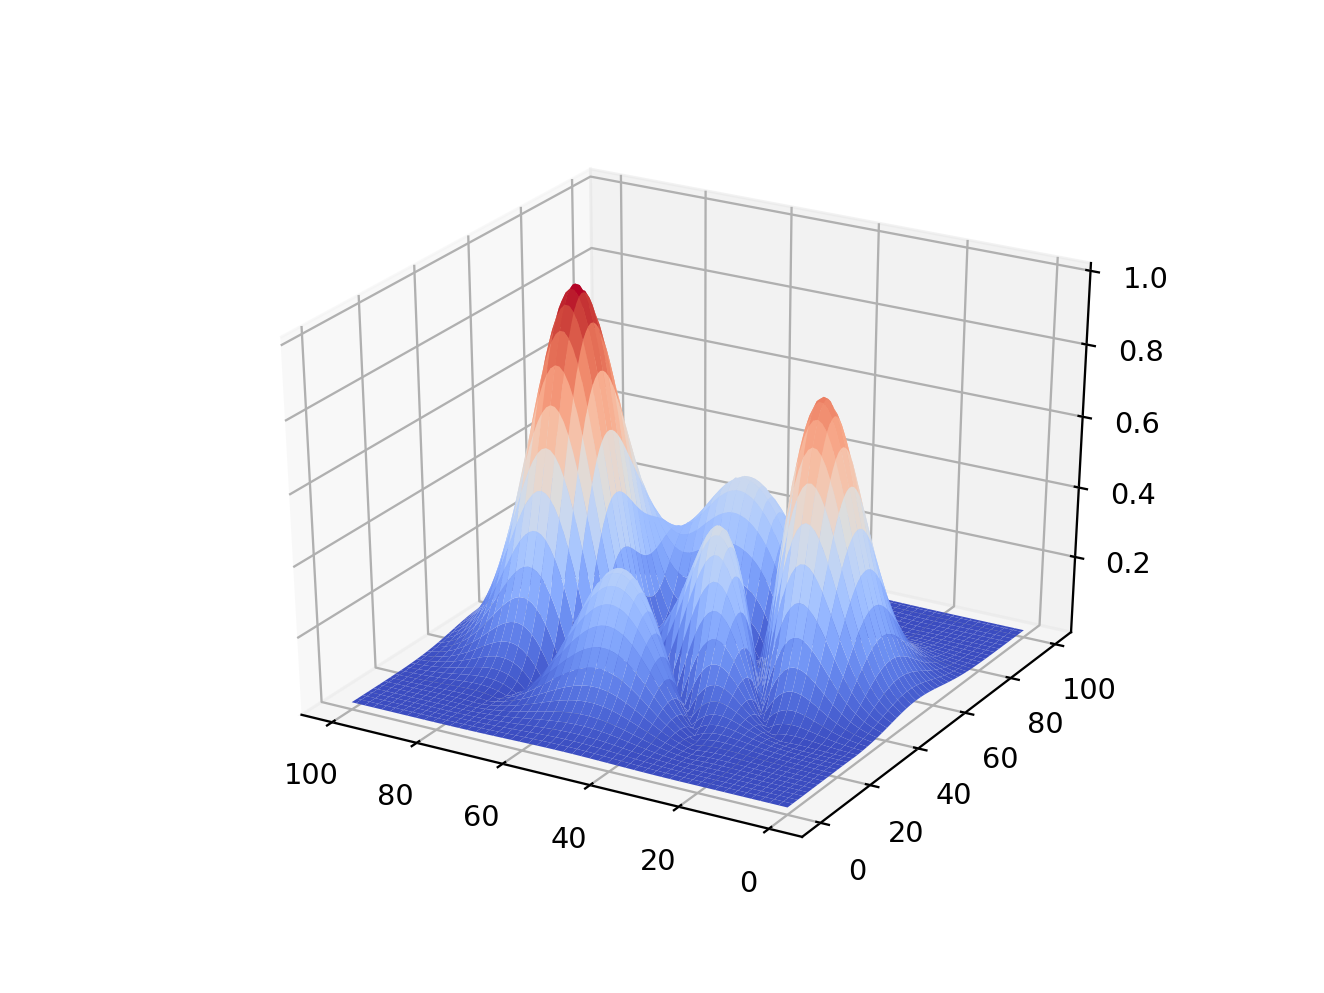

In [4]:
# Plot the 3D plot of pdf
# --------------------------

X = np.arange(0,100 + 100./(n-1), 100./(n-1))
Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
fig0 = plt.figure()
ax = fig0.gca(projection='3d')
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, pdf,rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
plt.gca().invert_xaxis()
plt.show()

**The Energy function**

It gives the distribution of energy in our pdf.

<IPython.core.display.Javascript object>


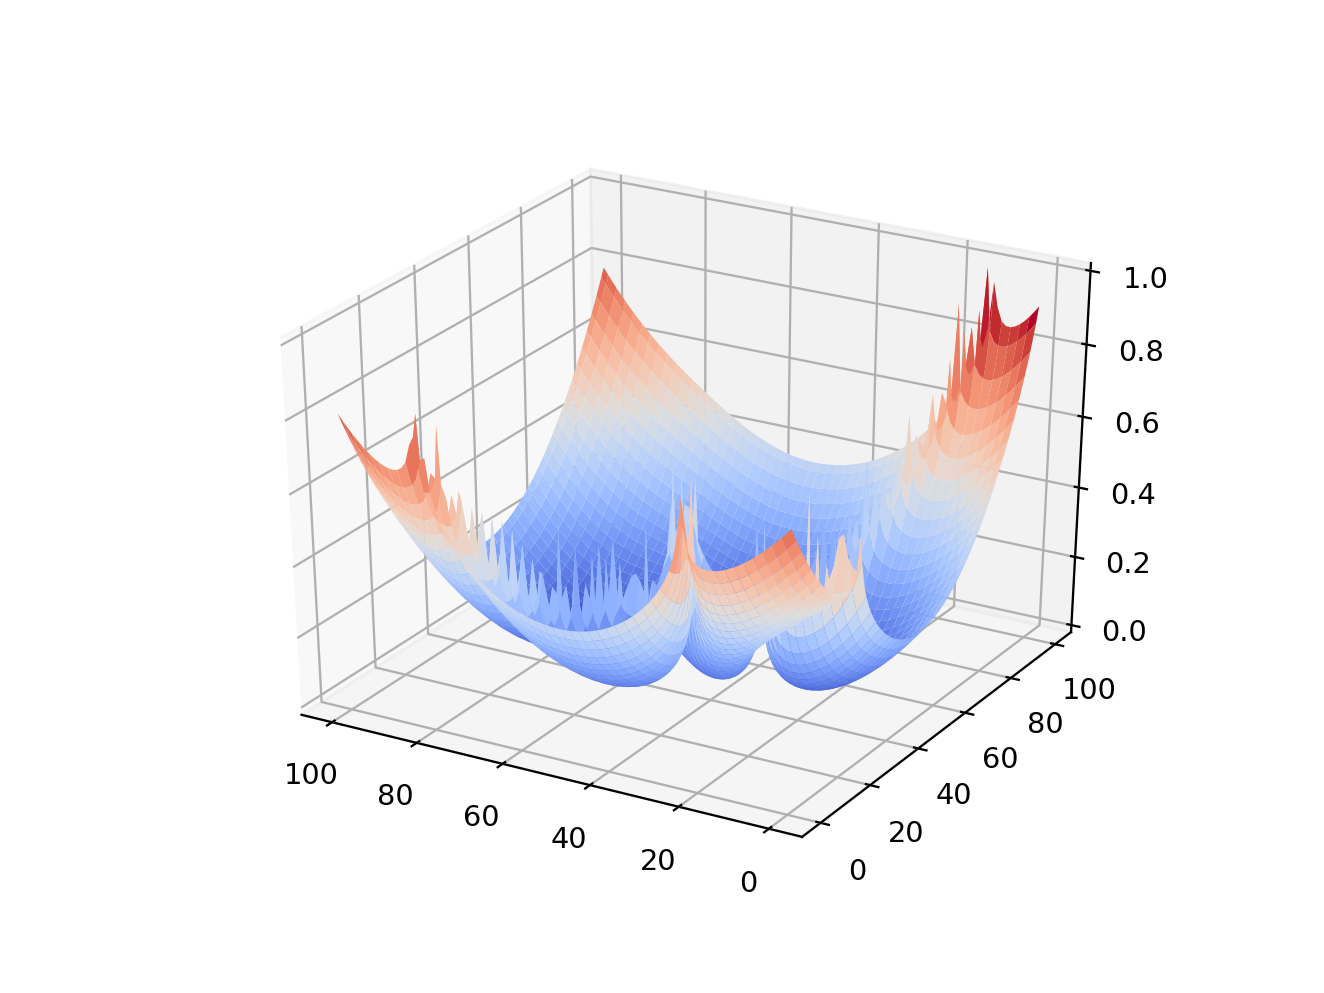

In [5]:
# Plot the 3D plot of Energy function
# --------------------------

X = np.arange(0,100 + 100./(n-1), 100./(n-1))
Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
fig0 = plt.figure()
ax = fig0.gca(projection='3d')
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, s/s.max(),rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
plt.gca().invert_xaxis()
plt.show()

**THE HEAT BATH**

For understanding how the temperature interacts with the probability distribution function, the notebook plots where $\sigma_M(m,T)$ is allowed to go in a given temperature. Each line represents an increase of factor of 10 of the temperature, starting with a hihg temperature of $T=10$, and finishing with $T=0.01$. As simulated annealing we  Finally the ones in the middle are the "Heat bath graphs", in which varies their values in the space vary with each temperature. 

<IPython.core.display.Javascript object>


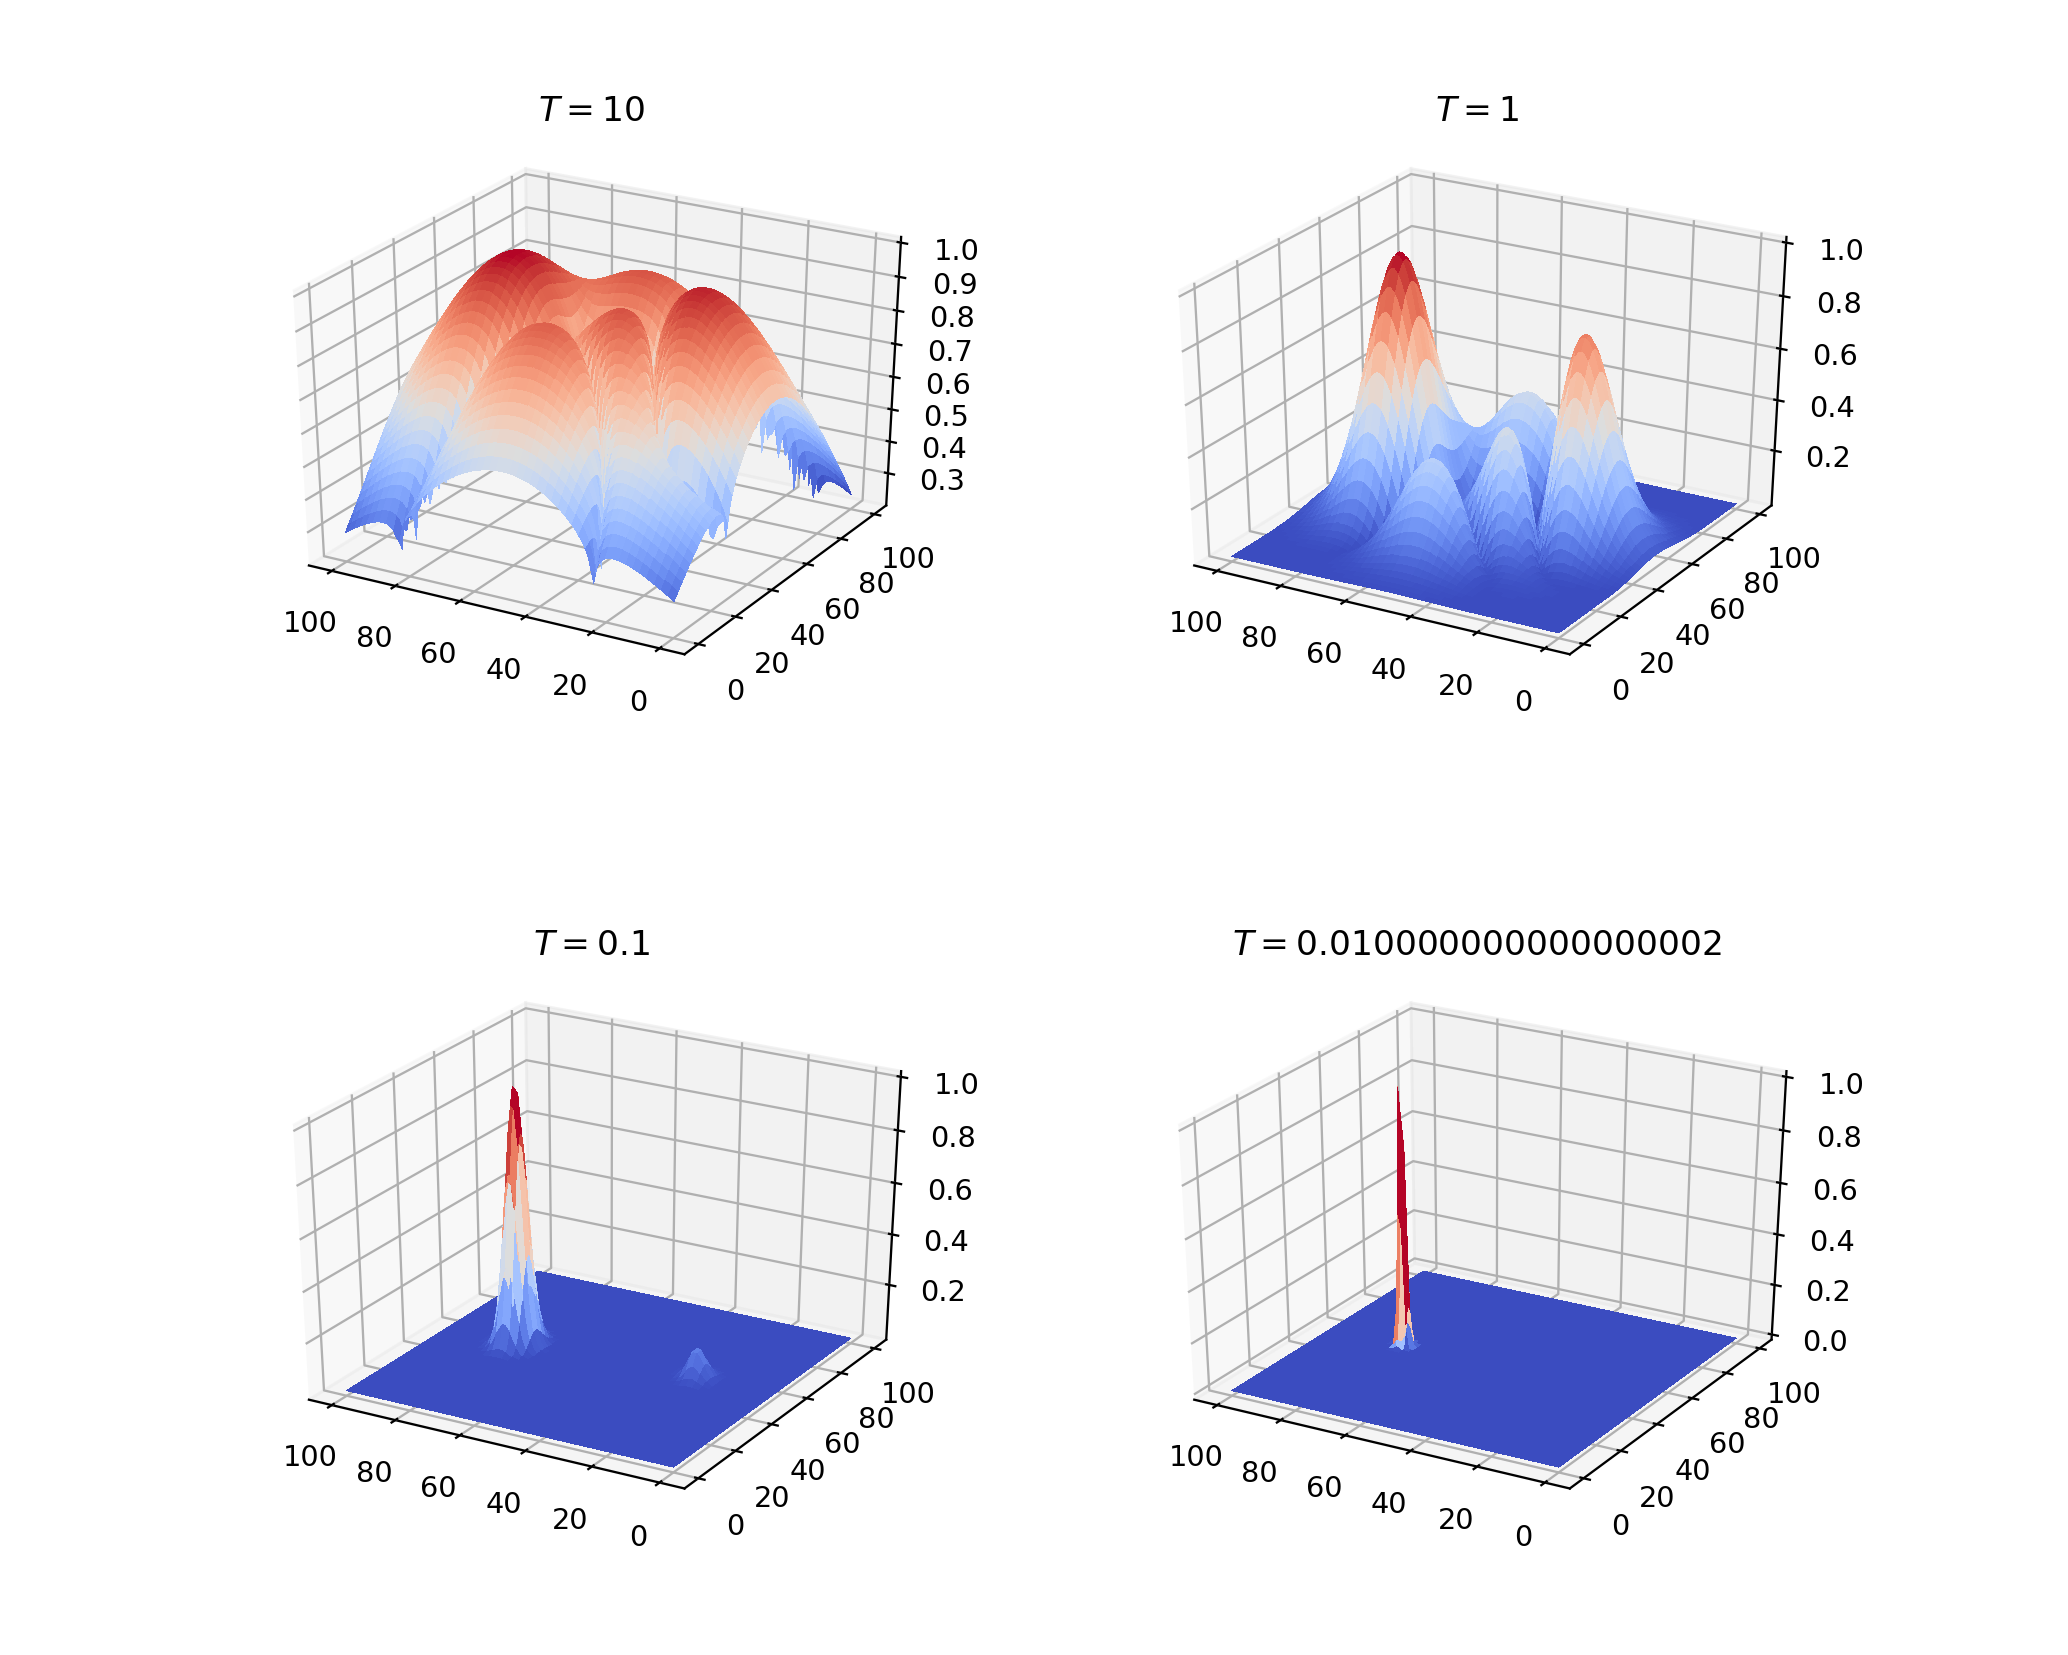

In [6]:
#The heat bath 
a = 1
fig0 = plt.figure(figsize=(10,8))
for i in range(0,stepT): 
    sigma = rho * np.exp(-(s)/Tplots) 
    sigma= sigma / sigma.max()
    
    if Tplots < 1: 
        temp='$T = $'+str(Tplots)+'\n'
    else: 
        temp= '$T = $'+str(int(Tplots))+'\n'
    
    Tplots = Tplots * 0.1
    b = 0
    X = np.arange(0,100 + 100./(n-1), 100./(n-1))
    Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
    ax = fig0.add_subplot(2, 2, a, projection='3d')
    X, Y = np.meshgrid(X, Y)
    ax.set_title(temp)
    ax.plot_surface(Y, X, sigma,rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    plt.gca().invert_xaxis()
    a += 1
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.90, hspace=0.5, wspace=0.15)

plt.show()

** SIMULATED ANNEALING: The algorithm **

Now that we saw how the temperature affects to the pdf we can develop the algorithm. The therminology will be the folowing: 

   – $X$ is the random vector, or the configuration.

   – $S_m$ is the system energy, the function value. 

   – $T$ is the system temperature.
    
   – $\Delta S$ is the difference in system energy between two steps ($\Delta S= S_m(X_{i+1}) - S_m (X_i)$). 
    

At each iteration on the temperature the program creates a $X_{i}$ and evaluates the point using the simulation model (pdf), finding an associated system energy. This move has to be accepted or not with respect to the previous one. 
  * if $S= S_m(X_{i+1}) < S_m (X_i)$ $\rightarrow$ accept $X_{i+1}$ as the new model (current_model =  new_model)
  * if $S= S_m(X_{i+1}) \geqslant S_m (X_i)$ $\rightarrow$ accept $X_{i+1}$ as the new model with probability $S =  exp (-\frac{\Delta S}{T})$ with $T = \alpha T$
  
beeing $\alpha$ the cooling schedule. 

At the end, the system will have reduced the temperature, according to the cooling choosen, towards 0. 

<IPython.core.display.Javascript object>


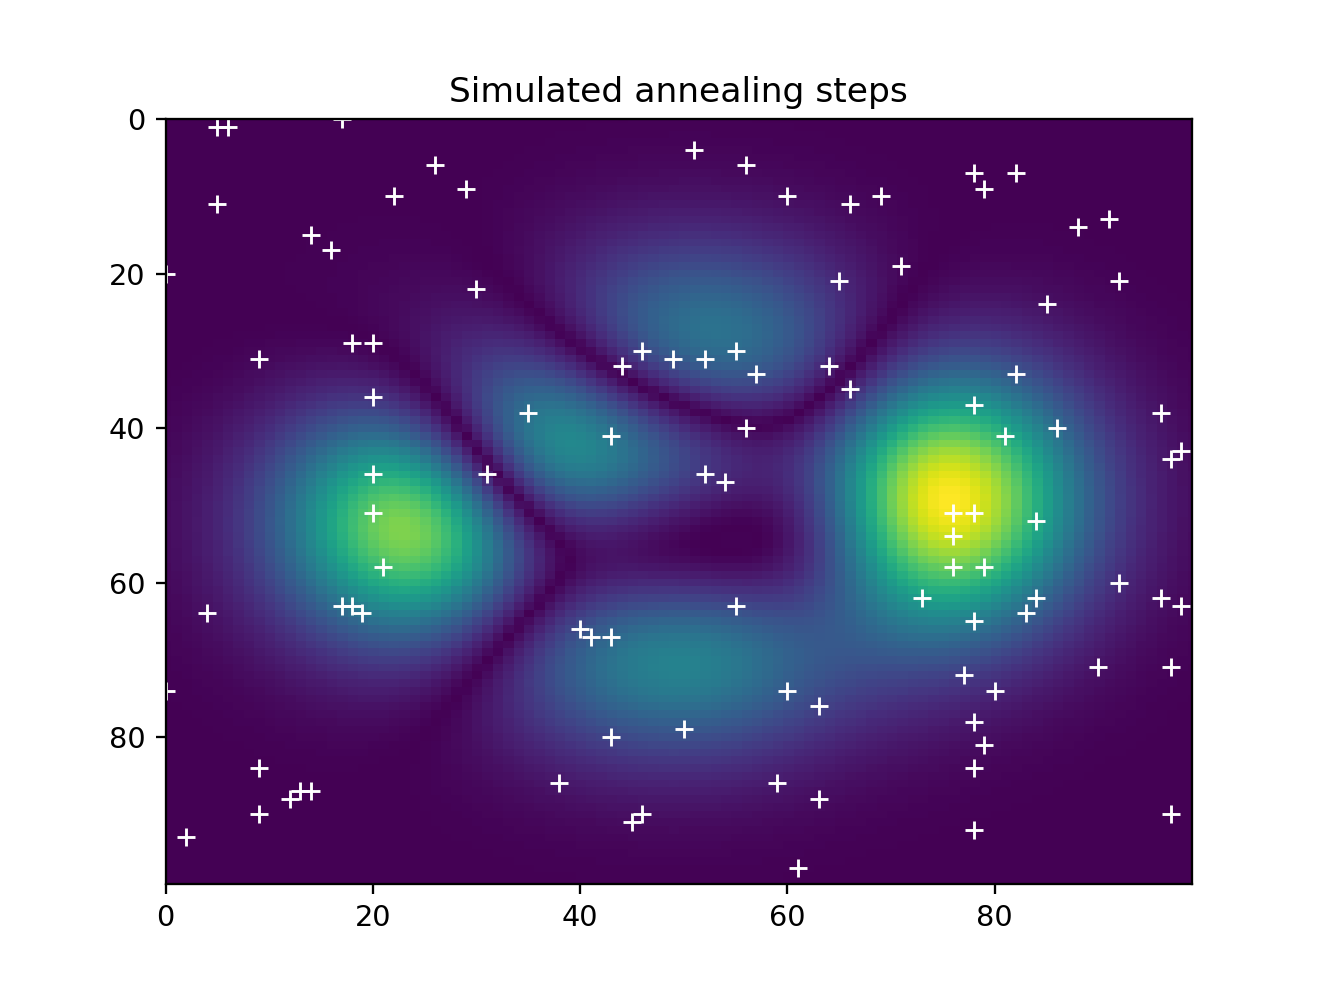

In [7]:
# Simulated annealing and ploting the steps

# find an initial vector x
xcur = np.array([np.floor(np.random.uniform(0, 100)), np.floor(np.random.uniform(0, 100))])

# Let s get moving
iis = 0
npp = 0
xa = np.array([])
xa = np.hstack((xa, np.array([xcur[0],xcur[1]])))

## Ploting the steps (initializing the graph)
fig = plt.figure()
f1 = fig.add_subplot(111)  
f1.imshow(pdf.transpose(),aspect='auto',interpolation='none', animated=True)
f1.set_xlim(0,99)
f1.set_ylim(99,0)
f1.set_title('Simulated annealing steps')
plt.ion() #set interactive mode
plt.show()

Pa = np.zeros(ns+1)
xnew = np.array([0.,0.])

Pa = [0]
while iis < ns: 
    npp = npp+1
    #make a random choice for the next move
    xnew = np.array([np.floor(np.random.uniform(0, 100)), np.floor(np.random.uniform(0, 100))])
    #compare probabilities
    Pcur = pdf[int(xcur[0]), int(xcur[1])]
    Pnew = pdf[int(xnew[0]), int(xnew[1])]
    
    T = alpha * T
    if Pnew >= Pcur:
        xcur = xnew
       # print ' Made the %i-th move to [%i,%i] ' %(iis+1, xcur[0], xcur[1])
        # display move graphically   
        f1.plot(xnew[0],xnew[1],'w+') #plot the steps with black +
        plt.gcf().canvas.draw() #show the update
        iis = iis + 1
    
    if Pnew < Pcur: 
        deltaP = Pcur - Pnew
        P = np.exp(-1. * deltaP / T)
        test = np.random.uniform(0,1)
        if test <= P: 
            xcur = xnew
            #print ' Made the %i-th move to [%i,%i] P= %g ' %(iis+1,xcur[0],xcur[1],P)
            # display move graphically
            f1.plot(xnew[0],xnew[1],'w+') # plot the steps with black +
            plt.gcf().canvas.draw()  #show the update
            iis = iis + 1
   
    xa = np.vstack((xa, np.array([xcur[0],xcur[1]])))
    Pa.append(Pnew)
    
plt.gcf().canvas.draw()
npp = npp + 1
Pa = np.array(Pa)

**FINAL SAMPLING **

To show how the program has proceded it is shown all the places where the program has gone in the sampling space, and the the maximum probability point found. Also, it is ploted as function of the iterations the best model and the current model. 

<IPython.core.display.Javascript object>


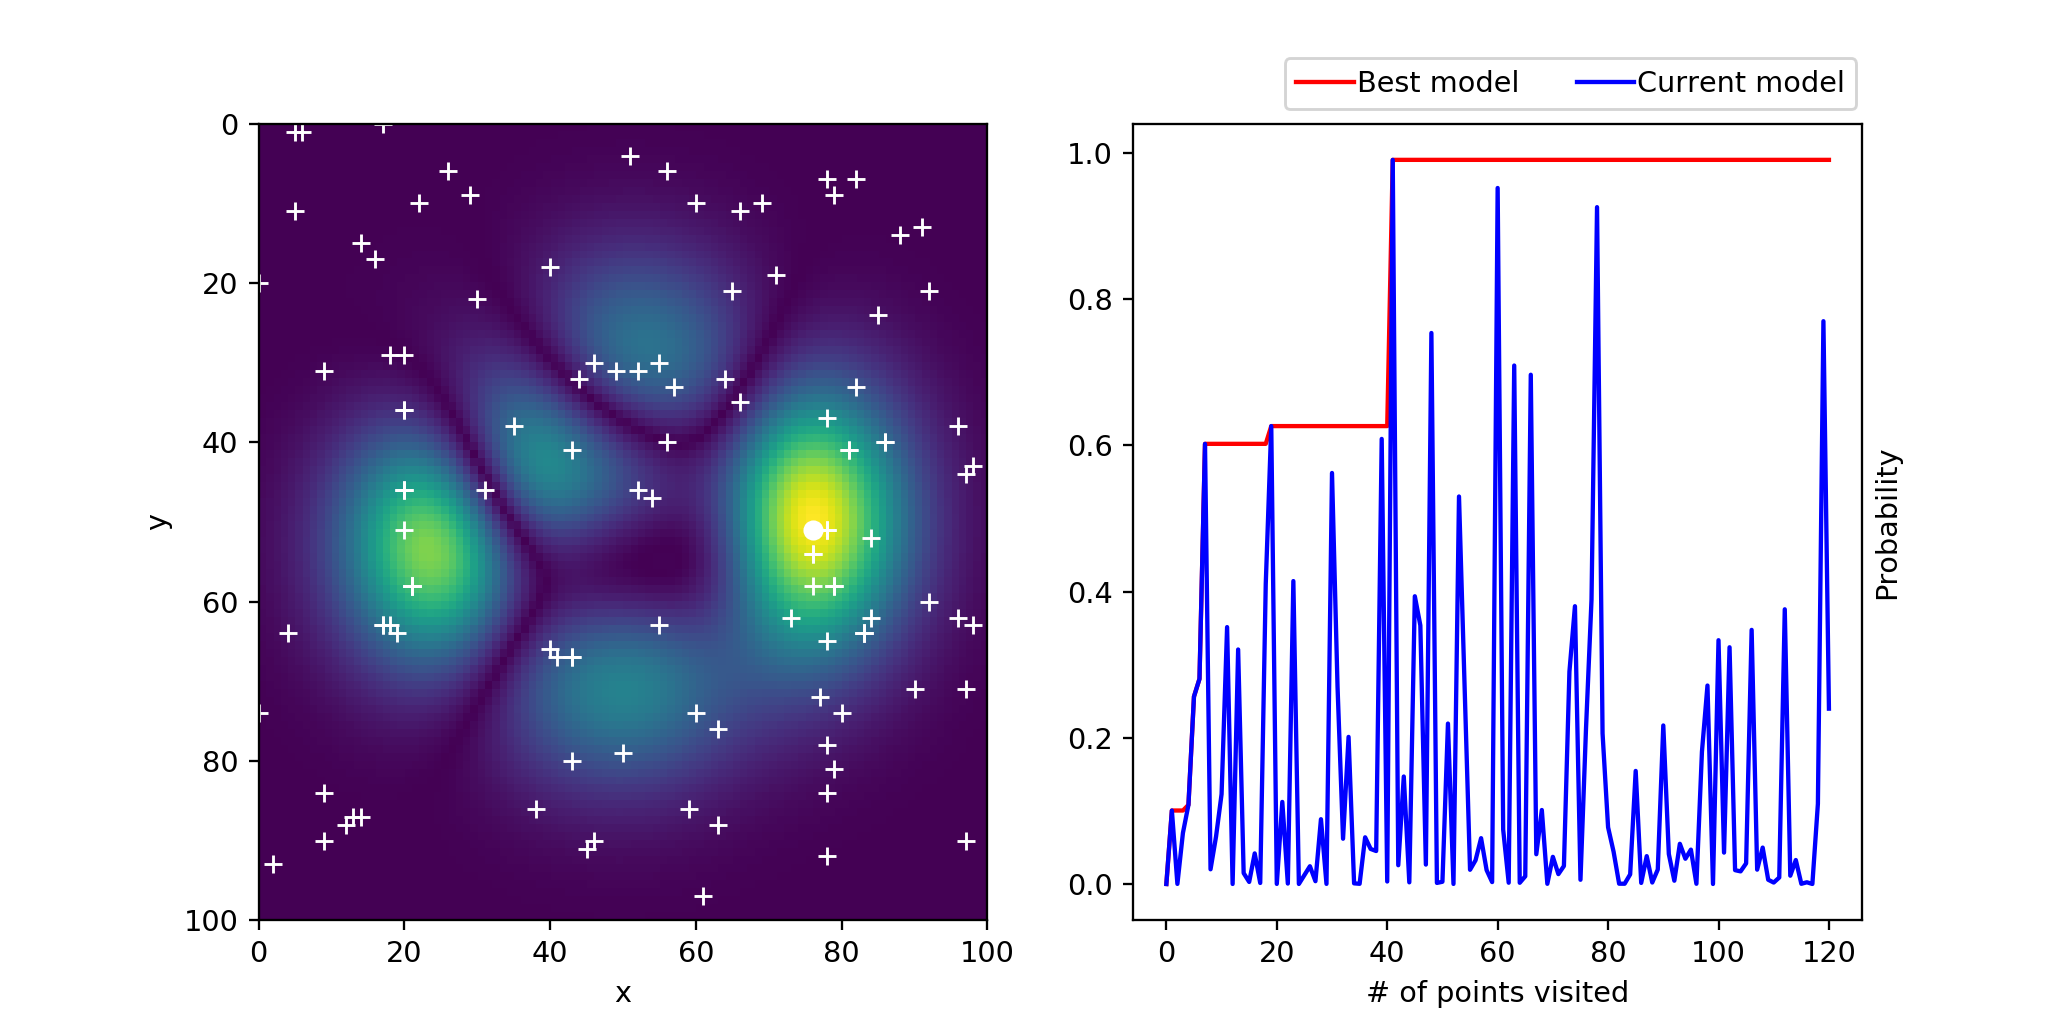

In [8]:
# Final sampling

#get max of Pa and the index for the best model
y = Pa.max()
for i in range(0,npp):
    if Pa[i] == y:
        maxi = i

#Ploting the results
fig2 = plt.figure(figsize=(10,5))

#First graph
f1 = fig2.add_subplot(121)
f1.imshow(pdf.transpose(),aspect='auto', extent=[0,100,100,0],interpolation='none')
f1.plot(xa[:,0],xa[:,1],'w+') #Plot the steps with white +
f1.plot(xa[maxi,0],xa[maxi,1],'wo') #Maximum value acchieved ploted wiht the white cirlce
f1.set_ylabel('y')
f1.set_xlabel('x')

#Second graph
f2 = fig2.add_subplot(122)
# Show as a function of the iterations 
# 1. the best model
# 2. the current model
best = np.zeros(npp)
for i in range(0,npp):
    a = Pa[0]
    for j in range(0,i+1):
        if Pa[j] > a:
            a = Pa[j]
    best[i] = a

f2.plot(range(0,npp),best,'r-', label='Best model')
f2.plot(range(0,npp),Pa,'b-', label='Current model')
f2.set_xlabel('# of points visited')
f2.yaxis.set_label_position("right")
f2.legend(loc='upper center', bbox_to_anchor=(0.6, 1.1), ncol=2, handletextpad=0.1)
f2.set_ylabel('Probability')

plt.show() 